<a href="https://colab.research.google.com/github/saravanan-06/desktop-tutorial/blob/main/Copy_of_Skin_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import kagglehub
subirbiswas19_skin_disease_dataset_path = kagglehub.dataset_download('subirbiswas19/skin-disease-dataset')

print('Data source import complete.')


100%|██████████| 17.3M/17.3M [00:01<00:00, 17.5MB/s]

Extracting files...


Data source import complete.


In [ ]:
# Libaries Required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import matplotlib.image as mpimg
from zipfile import ZipFile
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , models
from sklearn.utils.class_weight import compute_class_weight
import cv2
from tensorflow.keras.applications import ResNet152V2
import tensorflow as tf

**Importing dataset**

In [ ]:
import os

data_path = subirbiswas19_skin_disease_dataset_path
print(os.listdir(data_path))

['skin-disease-datasaet']


In [ ]:
inner_path = os.path.join(data_path, "skin-disease-datasaet")
print(os.listdir(inner_path))

['test_set', 'train_set']


(224, 224, 3)


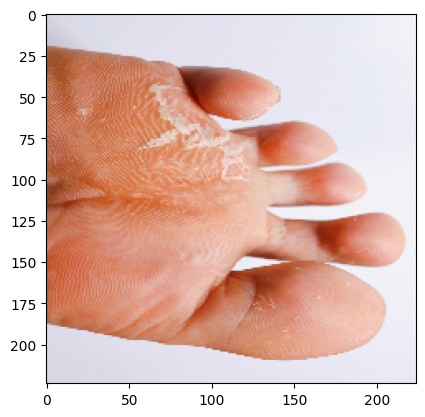

In [ ]:
# Providing path to dataset
base_dir = os.path.join(inner_path, "train_set")
image_path=os.path.join(base_dir, "FU-athlete-foot", "FU-athlete-foot (1).png")

# Reading the image
img=mpimg.imread(image_path)
print(img.shape)

#display image
plt.imshow(img)
plt.axis()
plt.show()

**Preprocessing of Image data**

In [ ]:
img_size = 224
batch_size = 32

def resize_and_pad(img):
    desired_size = 224
    old_size = img.shape[:2]  # (height, width)

    # Compute ratio and new size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    img = cv2.resize(img, (new_size[1], new_size[0]))

    # Padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img / 255.0  # Normalize [0, 1]

data_gen = ImageDataGenerator(
    preprocessing_function=resize_and_pad,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.25
)



train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    interpolation='bilinear',
    shuffle=True
)

valid_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    interpolation='bilinear',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
print("Class sample counts:", np.bincount(train_gen.classes))


Found 695 images belonging to 8 classes.
Found 229 images belonging to 8 classes.
Class indices: {'BA- cellulitis': 0, 'BA-impetigo': 1, 'FU-athlete-foot': 2, 'FU-nail-fungus': 3, 'FU-ringworm': 4, 'PA-cutaneous-larva-migrans': 5, 'VI-chickenpox': 6, 'VI-shingles': 7}
Class sample counts: [102  60  93  97  68  75 102  98]


Class Weights: {0: np.float64(0.8517156862745098), 1: np.float64(1.4479166666666667), 2: np.float64(0.9341397849462365), 3: np.float64(0.895618556701031), 4: np.float64(1.2775735294117647), 5: np.float64(1.1583333333333334), 6: np.float64(0.8517156862745098), 7: np.float64(0.8864795918367347)}


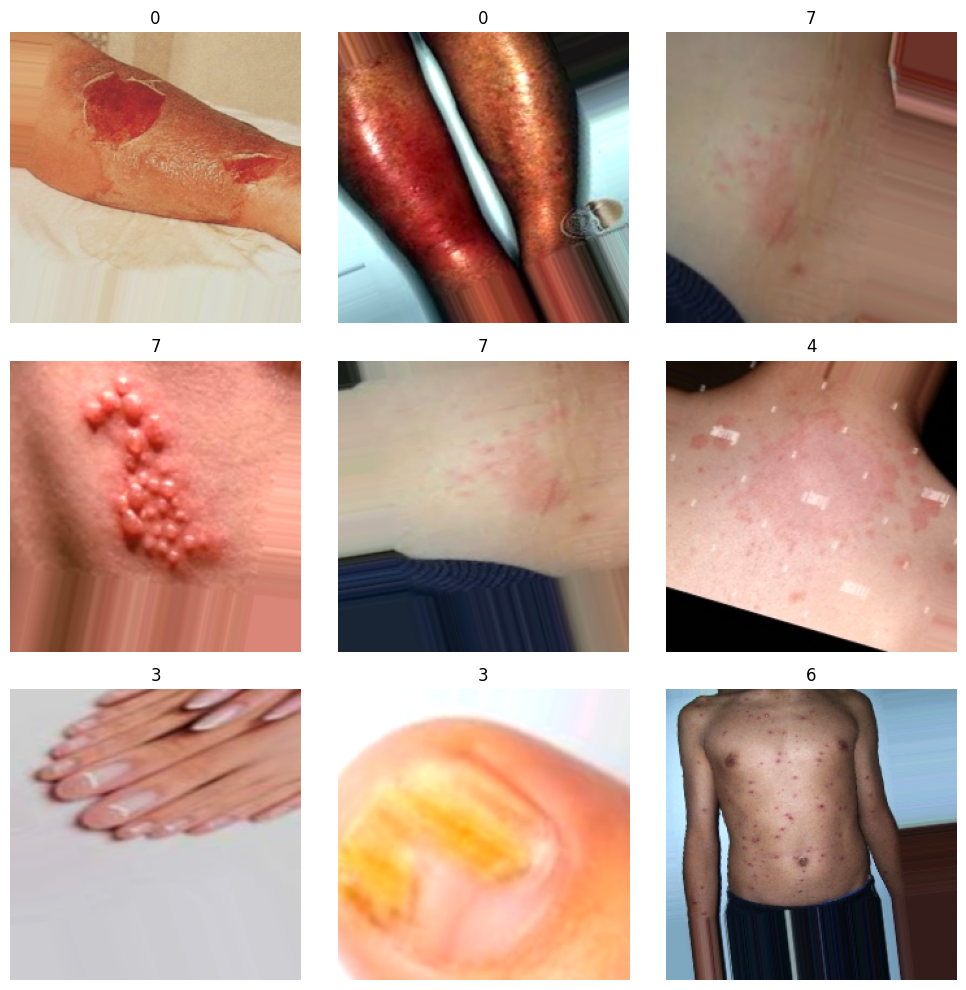

In [ ]:
#  Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Preview Images
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Model Creation
base_model = ResNet152V2(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,858,248 (224.53 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [ ]:
history=model.fit(
    train_gen,
    epochs=25,
    validation_data=valid_gen,
    class_weight=class_weights_dict
)

In [ ]:
print("Evaluating model........")
val_loss,val_accuracy=model.evaluate(valid_gen,steps=valid_gen.samples//batch_size)
print(f"validation accuracy:{val_accuracy*100:.2f}%")

Evaluating model........
7/7 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - accuracy: 0.8659 - loss: 0.3170
validation accuracy:89.73%


Classification Report i.e. **Accuracy,F1-Score,Precision,Recall**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true and predicted labels
Y_true = valid_gen.classes
Y_pred = np.argmax(model.predict(valid_gen), axis=1)

# Report
print(classification_report(Y_true, Y_pred, target_names=valid_gen.class_indices.keys()))


8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 14s/step
                            precision    recall  f1-score   support

            BA- cellulitis       0.94      0.94      0.94        33
               BA-impetigo       0.90      0.90      0.90        20
           FU-athlete-foot       0.96      0.87      0.92        31
            FU-nail-fungus       0.91      1.00      0.96        32
               FU-ringworm       1.00      0.86      0.93        22
PA-cutaneous-larva-migrans       0.86      0.76      0.81        25
             VI-chickenpox       0.92      1.00      0.96        34
               VI-shingles       0.83      0.91      0.87        32

                  accuracy                           0.91       229
                 macro avg       0.92      0.91      0.91       229
              weighted avg       0.91      0.91      0.91       229



Classification Report is quite good as f1 score is above 0.5 and model accuracy is around 92% so considering it we can create a prediction

In [ ]:
model.save('Skin_disease_model.h5')

Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


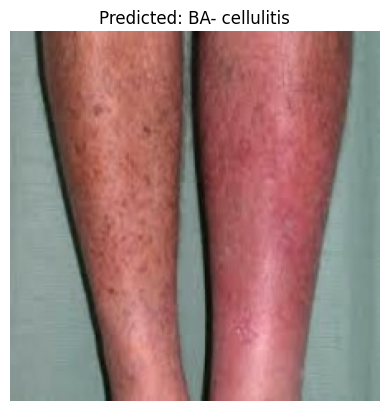

In [ ]:
from tensorflow.keras.models import load_model
from keras.utils import load_img, img_to_array
import os
import numpy as np

model = load_model("/content/Skin_disease_model.h5")

class_indices = {
    'BA- cellulitis': 0,
    'BA-impetigo': 1,
    'FU-athlete-foot': 2,
    'FU-nail-fungus': 3,
    'FU-ringworm': 4,
    'PA-cutaneous-larva-migrans': 5,
    'VI-chickenpox': 6,
    'VI-shingles': 7
}

index_to_label = {v: k for k, v in class_indices.items()}

test_base_dir = os.path.join(inner_path, "test_set")
img_path = os.path.join(test_base_dir, "BA- cellulitis", "BA- cellulitis (73).jpg")


img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

pred = model.predict(img_array)
predicted_index = np.argmax(pred)
predicted_label = index_to_label[predicted_index]


plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}")
plt.show()

Saving Screenshot 2025-07-24 140155.png to Screenshot 2025-07-24 140155.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
🩺 Predicted Disease: FU-athlete-foot


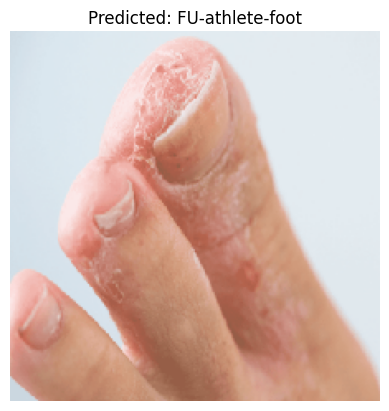

In [ ]:
from google.colab import files
from keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)


label_map = {v: k for k, v in train_gen.class_indices.items()}
print("🩺 Predicted Disease:", label_map.get(predicted_class, "Unknown"))

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {label_map.get(predicted_class, 'Unknown')}")
plt.show()

Saving Screenshot 2025-07-24 141051.png to Screenshot 2025-07-24 141051.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
🩺 Predicted Disease: FU-ringworm


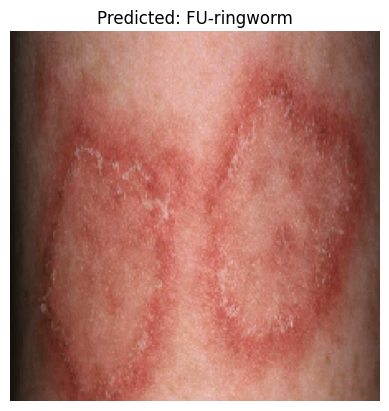

In [ ]:
from google.colab import files
from keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

label_map = {v: k for k, v in train_gen.class_indices.items()}
print("🩺 Predicted Disease:", label_map.get(predicted_class, "Unknown"))

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {label_map.get(predicted_class, 'Unknown')}")
plt.show()